In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import zoo_of_odes
import ode_collapser
from tqdm.auto import tqdm

# ODE selection experiment

The purpose of this notebook is to verify that the ODE-collapse method really can distinguish which ODE data was generated from.
To do this, we will select a number of ODEs (or "systems"), and construct a _realization_ of that system by integrating from initial conditions, and then sample a dataset from that.

For each dataset, we will run ODE-collapser for each system, not only the systems that generated that dataset.

We will denote the datasets by, for example, `SHO1-R2` to indicate _the second realization of the first Simple Harmonic Oscillator system_.

In [2]:
systems = {
    'SHO1': {
        'ode_name': 'damped_harmonic_oscillator',
        'params': {
            'omega': 2*np.pi*3.0,
            'nu': 0.0,
        },
        'initial_conditions': [
            {'amplitude0': 1.2, 'phase0': np.pi/4},
            {'amplitude0': 0.8, 'phase0': 0.0},
            {'amplitude0': 1.2, 'phase0': -np.pi/4},
        ],
    },
    'QD1': {
        'ode_name': 'harmonic_oscillator_with_quadratic_drag',
        'params': {
            'omega': 2*np.pi*3.0,
            'nu': 1.0,
        },
        'initial_conditions': [
            {'x0': 0.85, 'v0': 16.0},
            {'x0': 0.85, 'v0': -16.0},
        ]
    },
    'QD2': {
        'ode_name': 'harmonic_oscillator_with_quadratic_drag',
        'params': {
            'omega': 2*np.pi*2.0,
            'nu': 0.5,
        },
        'initial_conditions': [
            {'x0': 0.85, 'v0': 16.0},
            {'x0': 0.85, 'v0': -16.0},
        ]
    },
    'CA1': {
        'ode_name': 'constant_acceleration',
        'params': {'a': -10.0},
        'initial_conditions': [
            {'x0': 0.0, 'v0': 2.0},
            {'x0': 2.0, 'v0': 0.0},
        ]
    },
    'CA2': {
        'ode_name': 'constant_acceleration',
        'params': {'a': -5.0},
        'initial_conditions': [
            {'x0': 0.0, 'v0': 2.0},
            {'x0': 2.0, 'v0': 0.0},
        ]
    },
}

In [3]:
# Parameters
t_start = 0.0
t_end = 1.0
h = 0.01
sigma = 0.1  # Noise level for data generation
N_samples = 10
rng_seed_data = 1234

In [4]:
# Get underlying solutions from either the analytic solution of a numerical integrator
underlying_solutions = {
    f'{system_name}-R{realization+1}': zoo_of_odes.get_solution(
        ode_name=system_spec['ode_name'],
        params=system_spec['params'],
        initial_conditions=ics,
        t_start=t_start,
        t_end=t_end,
        h=h,
    )
    for system_name, system_spec in systems.items()
    for realization, ics in enumerate(system_spec['initial_conditions'])
}

In [5]:
# Sample points from each realization
rng_data = np.random.RandomState(rng_seed_data)

def sample(xs, ts):
    idx_samples = rng_data.choice(ts.shape[0], size=N_samples, replace=False)
    idx_samples = np.sort(idx_samples)
    x_noise = rng_data.normal(scale=sigma, size=(N_samples,))
    t_samples = ts[idx_samples]
    x_samples = xs[idx_samples] + x_noise
    return x_samples, t_samples, idx_samples

samples = {
    realization_name: sample(x_true_grid, t_grid)
    for realization_name, (x_true_grid, t_grid) in underlying_solutions.items()
}
del rng_data

In [6]:
# You are able to plot the underlying and the data at this point if you wish.
# realization_to_plot = 'QD1-R2'
# fig, ax = plt.subplots()
# ax.plot(underlying_solutions[realization_to_plot][1], underlying_solutions[realization_to_plot][0],
#         ls='-', marker='none', label='True solution')
# ax.plot(samples[realization_to_plot][1], samples[realization_to_plot][0],
#         ls='none', marker='o', alpha=0.7, label='Samples / measurements')
# ax.set_xlim(left=underlying_solutions[realization_to_plot][1][0], right=underlying_solutions[realization_to_plot][1][-1])
# ax.set_xlabel('t')
# ax.set_ylabel('x(t)')
# ax.legend()

# plt.show()

In [7]:
# Run optimization with every system on every realization.
# Note that this may take some time.
optimization_results = {}
for realization_name, (x_samples, t_samples, idx_samples) in tqdm(samples.items(), desc='Realizations', leave=True):
    optimization_results[realization_name] = {}
    for system_name, system_spec in tqdm(systems.items(), desc='Systems', leave=False):
        optimization_results[realization_name][system_name] = ode_collapser.collapse_to_solution(
            rhs=zoo_of_odes.get_rhs_func(system_spec['ode_name'], system_spec['params']),
            h=h,
            t_start=t_start,
            t_end=t_end,
            idx_samples=idx_samples,
            x_samples=x_samples,
            show_progress=False,
        )

Realizations:   0%|          | 0/11 [00:00<?, ?it/s]

Systems:   0%|          | 0/5 [00:00<?, ?it/s]

Systems:   0%|          | 0/5 [00:00<?, ?it/s]

Systems:   0%|          | 0/5 [00:00<?, ?it/s]

Systems:   0%|          | 0/5 [00:00<?, ?it/s]

Systems:   0%|          | 0/5 [00:00<?, ?it/s]

Systems:   0%|          | 0/5 [00:00<?, ?it/s]

Systems:   0%|          | 0/5 [00:00<?, ?it/s]

Systems:   0%|          | 0/5 [00:00<?, ?it/s]

Systems:   0%|          | 0/5 [00:00<?, ?it/s]

Systems:   0%|          | 0/5 [00:00<?, ?it/s]

Systems:   0%|          | 0/5 [00:00<?, ?it/s]

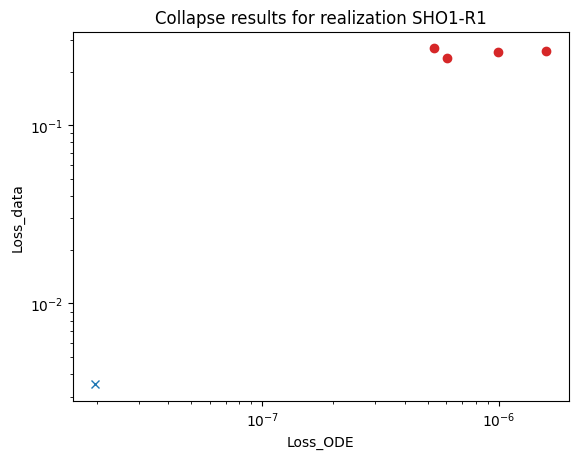

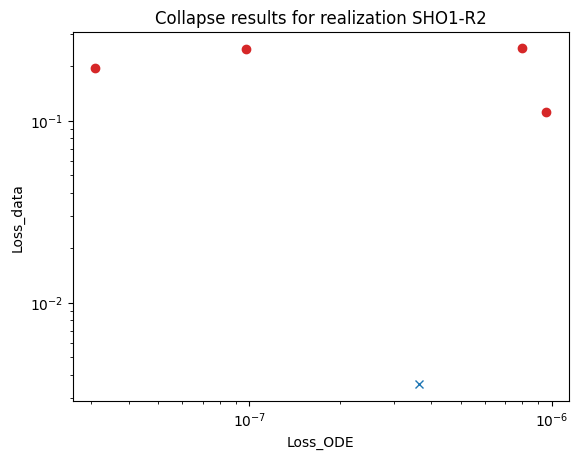

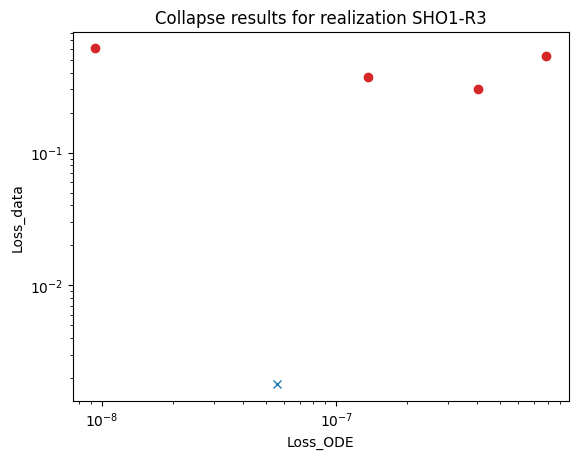

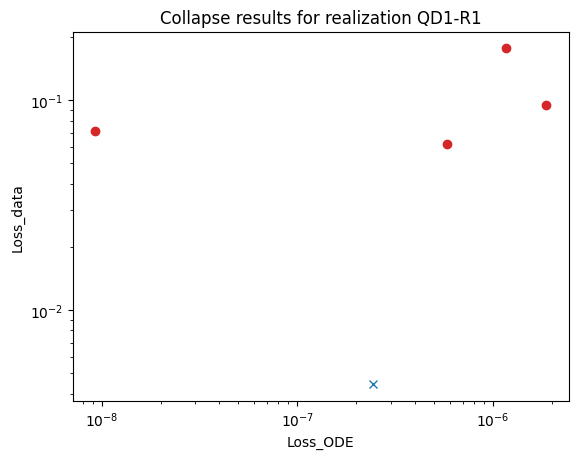

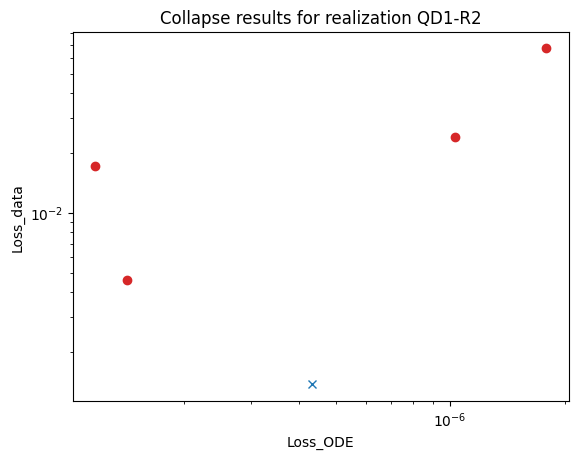

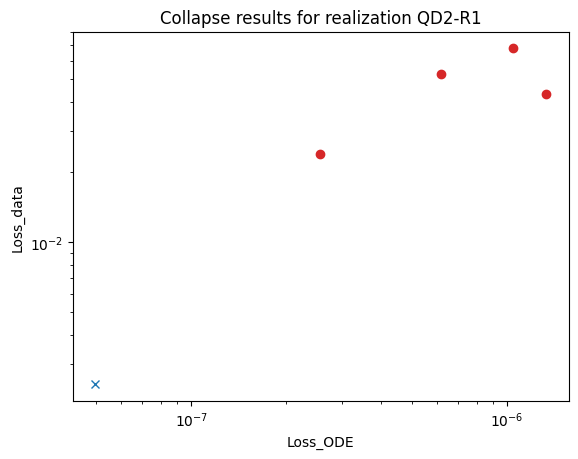

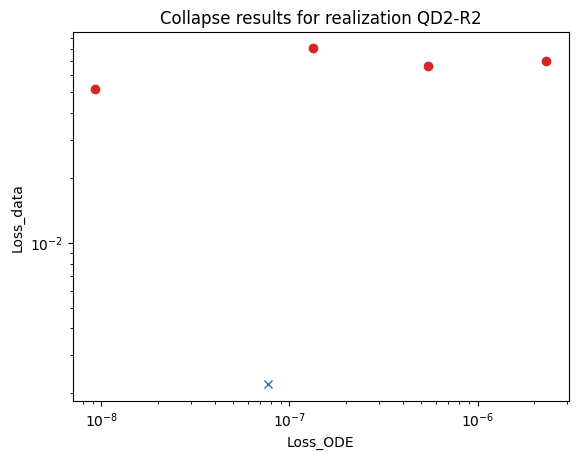

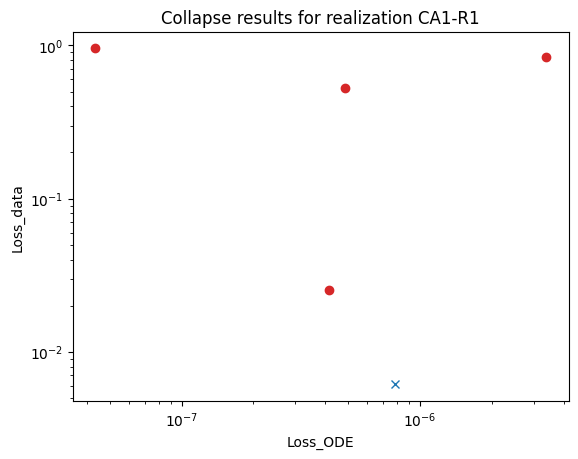

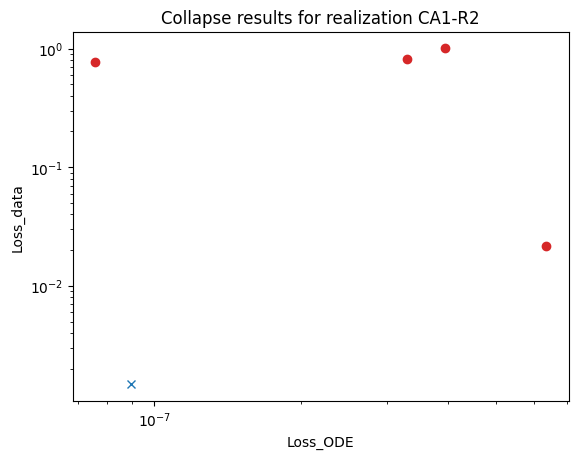

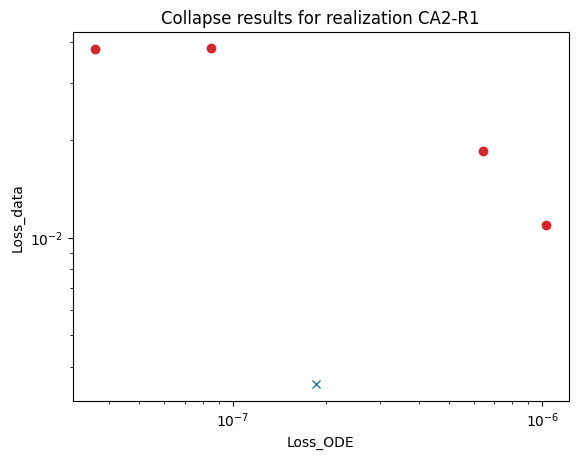

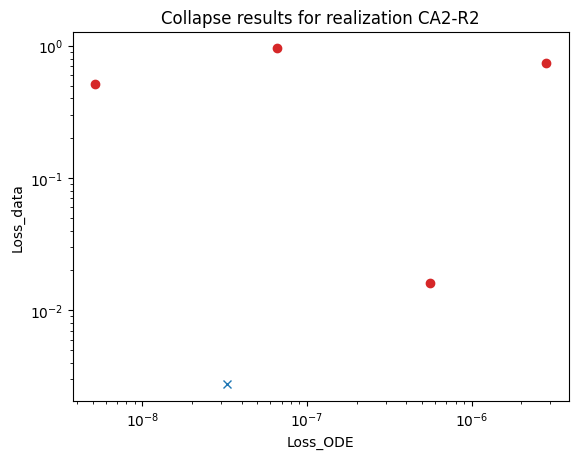

In [8]:
for realization_name in optimization_results.keys():
    fig, ax = plt.subplots()
    
    regex_system_part = re.compile(r'(.*)-R[0-9]+')
    for system_name in systems.keys():
        is_right_system = regex_system_part.match(realization_name).group(1) == system_name
    
        loss_data = optimization_results[realization_name][system_name]['log_scalars'][-1]['loss_data']
        loss_ODE = optimization_results[realization_name][system_name]['log_scalars'][-1]['loss_ODE']
    
        marker = 'x' if is_right_system else 'o'
        color = 'tab:blue' if is_right_system else 'tab:red'
        ax.plot(loss_ODE, loss_data, ls='none', marker=marker, color=color)
    
    ax.set_xlabel('Loss_ODE')
    ax.set_ylabel('Loss_data')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Collapse results for realization {realization_name}')
    plt.show()